In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('Hotel Reservations.csv')
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [2]:
feature_name = 'avg_price_per_room'

# Calculate the IQR
Q1 = df[feature_name].quantile(0.25)
Q3 = df[feature_name].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold for outliers (e.g., 1.5 times the IQR)
outlier_threshold = 1.5

# Identify outliers based on the IQR
outliers = df[(df[feature_name] < Q1 - outlier_threshold * IQR) | (df[feature_name] > Q3 + outlier_threshold * IQR)]

# Print or visualize the outliers
#print("Outliers:")
#print(outliers)

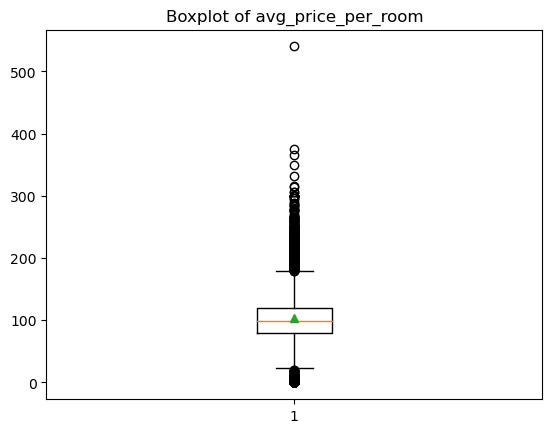

(34579, 19) 2


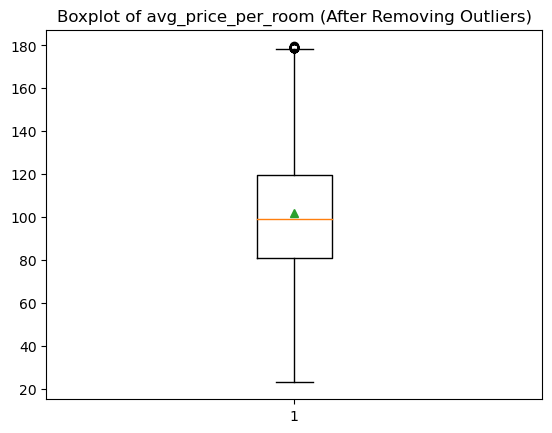

In [3]:
plt.boxplot(df.avg_price_per_room, showmeans=True)
plt.title('Boxplot of avg_price_per_room')
plt.show()
# removing the outliers
# Calculate IQR for the column
Q1 = df['avg_price_per_room'].quantile(0.25)
Q3 = df['avg_price_per_room'].quantile(0.75)
IQR = Q3 - Q1
# Identify and remove outliers
df = df[~((df['avg_price_per_room'] < (Q1 - 1.5 * IQR)) | (df['avg_price_per_room'] > (Q3 + 1.5 * IQR)))]
print(df.shape, "2") # (34579, 19)
plt.boxplot(df.avg_price_per_room, showmeans=True)
plt.title('Boxplot of avg_price_per_room (After Removing Outliers)')
plt.show()

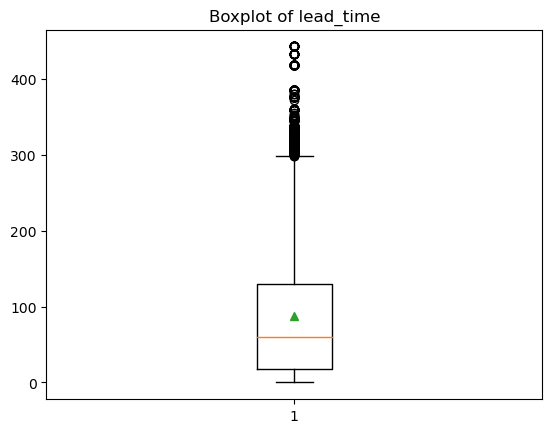

(33462, 19) 3


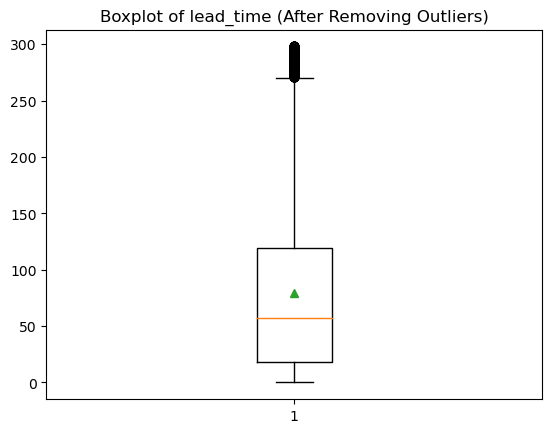

In [4]:
plt.boxplot(df.lead_time, showmeans=True)
plt.title('Boxplot of lead_time')
plt.show()
Q1 = df['lead_time'].quantile(0.25)
Q3 = df['lead_time'].quantile(0.75)
IQR = Q3 - Q1
# Identify and remove outliers
df = df[~((df['lead_time'] < (Q1 - 1.5 * IQR)) | (df['lead_time'] > (Q3 + 1.5 * IQR)))]
print(df.shape, "3") # (33462, 19)
plt.boxplot(df.lead_time, showmeans=True)
plt.title('Boxplot of lead_time (After Removing Outliers)')
plt.show()

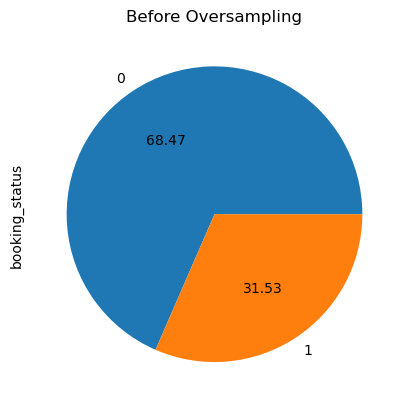

In [5]:
df['type_of_meal_plan'] = df['type_of_meal_plan'].replace({
    "Not Selected": 0,
    "Meal Plan 1": 1, 
    "Meal Plan 2": 2,
    "Meal Plan 3": 3,
    
})

df['room_type_reserved'] = df['room_type_reserved'].replace({
    "Room_Type 1": 1,
    "Room_Type 2": 2,
    "Room_Type 3": 3,
    "Room_Type 4": 4,
    "Room_Type 5": 5,
    "Room_Type 6": 6,
    "Room_Type 7": 7,
})

df['market_segment_type'] = df['market_segment_type'].replace({
    "Online": 1,
    "Offline": 2,
    "Corporate": 3,
    "Aviation": 4,
    "Complementary": 5,
    
})

df = df.drop('Booking_ID', axis=1)

df['booking_status'] = df['booking_status'].replace({
    "Canceled": 1,
    "Not_Canceled": 0,
})

X = df.drop('booking_status', axis=1).copy()
y = df['booking_status'].copy()

ax = y.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Before Oversampling")

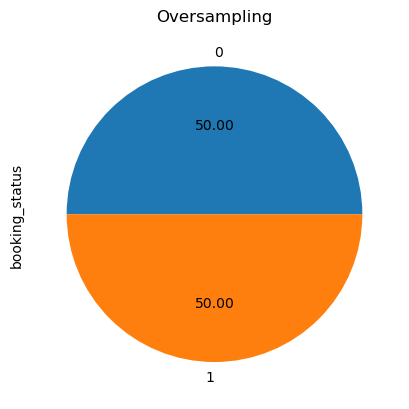

In [6]:
ros = SVMSMOTE(random_state=0)
X_res, y_res = ros.fit_resample(X, y)

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Oversampling")

In [8]:
# Train-Test Split
X_train, X_valid, y_train, y_valid = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',  # for binary classification
    'eval_metric': 'logloss',  # Logarithmic Loss
    'n_estimators': 2000,  # A large number to start; early stopping will decide the actual number
    'early_stopping_rounds': 300,  # Number of rounds to wait for performance improvement
    'verbose': 0  # Set to 1 to see training progress
}

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Train the XGBoost model with early stopping
model = xgb.train(params, dtrain, num_boost_round=params['n_estimators'], evals=[(dvalid, 'validation')])

# Get the best iteration (number of boosting rounds)
best_iteration = model.best_iteration

# Make predictions with the best model
y_pred = model.predict(dvalid, ntree_limit=best_iteration)

# Convert probabilities to class labels (0 or 1)
y_pred_labels = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate the accuracy on the validation set
accuracy = accuracy_score(y_valid, y_pred_labels)
conf_matrix = confusion_matrix(y_valid, y_pred_labels)
clf_report = classification_report(y_valid, y_pred_labels)

print(f"Accuracy Score: {accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{clf_report}")

[0]	validation-logloss:0.56093
[1]	validation-logloss:0.48841
[2]	validation-logloss:0.43883
[3]	validation-logloss:0.40587
[4]	validation-logloss:0.38268
[5]	validation-logloss:0.36898
[6]	validation-logloss:0.35861
[7]	validation-logloss:0.35061
[8]	validation-logloss:0.34604
[9]	validation-logloss:0.34063
[10]	validation-logloss:0.33813
[11]	validation-logloss:0.33325
[12]	validation-logloss:0.33144
[13]	validation-logloss:0.32394
[14]	validation-logloss:0.32178
[15]	validation-logloss:0.32043
[16]	validation-logloss:0.31869
[17]	validation-logloss:0.31270
[18]	validation-logloss:0.30783
[19]	validation-logloss:0.30630
[20]	validation-logloss:0.30566
[21]	validation-logloss:0.30303
[22]	validation-logloss:0.30256
[23]	validation-logloss:0.29946
[24]	validation-logloss:0.29710
[25]	validation-logloss:0.29391
[26]	validation-logloss:0.29321
[27]	validation-logloss:0.29229
[28]	validation-logloss:0.29189
[29]	validation-logloss:0.29063
[30]	validation-logloss:0.28955


C:\Users\admin\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:30:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_stopping_rounds", "n_estimators", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation-logloss:0.28876
[32]	validation-logloss:0.28614
[33]	validation-logloss:0.28398
[34]	validation-logloss:0.28159
[35]	validation-logloss:0.28050
[36]	validation-logloss:0.27862
[37]	validation-logloss:0.27809
[38]	validation-logloss:0.27791
[39]	validation-logloss:0.27706
[40]	validation-logloss:0.27686
[41]	validation-logloss:0.27620
[42]	validation-logloss:0.27552
[43]	validation-logloss:0.27316
[44]	validation-logloss:0.27295
[45]	validation-logloss:0.27179
[46]	validation-logloss:0.26931
[47]	validation-logloss:0.26913
[48]	validation-logloss:0.26761
[49]	validation-logloss:0.26734
[50]	validation-logloss:0.26643
[51]	validation-logloss:0.26494
[52]	validation-logloss:0.26406
[53]	validation-logloss:0.26326
[54]	validation-logloss:0.26259
[55]	validation-logloss:0.26051
[56]	validation-logloss:0.26004
[57]	validation-logloss:0.25990
[58]	validation-logloss:0.25947
[59]	validation-logloss:0.25855
[60]	validation-logloss:0.25837
[61]	validation-logloss:0.25771
[62]	val

[281]	validation-logloss:0.21331
[282]	validation-logloss:0.21305
[283]	validation-logloss:0.21287
[284]	validation-logloss:0.21269
[285]	validation-logloss:0.21264
[286]	validation-logloss:0.21254
[287]	validation-logloss:0.21260
[288]	validation-logloss:0.21238
[289]	validation-logloss:0.21223
[290]	validation-logloss:0.21239
[291]	validation-logloss:0.21217
[292]	validation-logloss:0.21205
[293]	validation-logloss:0.21202
[294]	validation-logloss:0.21184
[295]	validation-logloss:0.21189
[296]	validation-logloss:0.21190
[297]	validation-logloss:0.21167
[298]	validation-logloss:0.21148
[299]	validation-logloss:0.21134
[300]	validation-logloss:0.21131
[301]	validation-logloss:0.21141
[302]	validation-logloss:0.21128
[303]	validation-logloss:0.21122
[304]	validation-logloss:0.21130
[305]	validation-logloss:0.21120
[306]	validation-logloss:0.21113
[307]	validation-logloss:0.21110
[308]	validation-logloss:0.21118
[309]	validation-logloss:0.21115
[310]	validation-logloss:0.21123
[311]	vali

[529]	validation-logloss:0.21134
[530]	validation-logloss:0.21137
[531]	validation-logloss:0.21138
[532]	validation-logloss:0.21137
[533]	validation-logloss:0.21155
[534]	validation-logloss:0.21155
[535]	validation-logloss:0.21168
[536]	validation-logloss:0.21178
[537]	validation-logloss:0.21175
[538]	validation-logloss:0.21177
[539]	validation-logloss:0.21166
[540]	validation-logloss:0.21162
[541]	validation-logloss:0.21159
[542]	validation-logloss:0.21164
[543]	validation-logloss:0.21167
[544]	validation-logloss:0.21166
[545]	validation-logloss:0.21163
[546]	validation-logloss:0.21175
[547]	validation-logloss:0.21171
[548]	validation-logloss:0.21168
[549]	validation-logloss:0.21174
[550]	validation-logloss:0.21178
[551]	validation-logloss:0.21182
[552]	validation-logloss:0.21186
[553]	validation-logloss:0.21181
[554]	validation-logloss:0.21186
[555]	validation-logloss:0.21182
[556]	validation-logloss:0.21190
[557]	validation-logloss:0.21192
[558]	validation-logloss:0.21198
[559]	vali

[778]	validation-logloss:0.21871
[779]	validation-logloss:0.21873
[780]	validation-logloss:0.21874
[781]	validation-logloss:0.21877
[782]	validation-logloss:0.21871
[783]	validation-logloss:0.21871
[784]	validation-logloss:0.21872
[785]	validation-logloss:0.21881
[786]	validation-logloss:0.21884
[787]	validation-logloss:0.21882
[788]	validation-logloss:0.21886
[789]	validation-logloss:0.21881
[790]	validation-logloss:0.21899
[791]	validation-logloss:0.21897
[792]	validation-logloss:0.21907
[793]	validation-logloss:0.21904
[794]	validation-logloss:0.21910
[795]	validation-logloss:0.21905
[796]	validation-logloss:0.21912
[797]	validation-logloss:0.21916
[798]	validation-logloss:0.21917
[799]	validation-logloss:0.21921
[800]	validation-logloss:0.21928
[801]	validation-logloss:0.21934
[802]	validation-logloss:0.21936
[803]	validation-logloss:0.21922
[804]	validation-logloss:0.21920
[805]	validation-logloss:0.21912
[806]	validation-logloss:0.21916
[807]	validation-logloss:0.21918
[808]	vali

[1025]	validation-logloss:0.22854
[1026]	validation-logloss:0.22853
[1027]	validation-logloss:0.22863
[1028]	validation-logloss:0.22864
[1029]	validation-logloss:0.22863
[1030]	validation-logloss:0.22872
[1031]	validation-logloss:0.22892
[1032]	validation-logloss:0.22902
[1033]	validation-logloss:0.22913
[1034]	validation-logloss:0.22911
[1035]	validation-logloss:0.22923
[1036]	validation-logloss:0.22928
[1037]	validation-logloss:0.22933
[1038]	validation-logloss:0.22932
[1039]	validation-logloss:0.22937
[1040]	validation-logloss:0.22935
[1041]	validation-logloss:0.22939
[1042]	validation-logloss:0.22937
[1043]	validation-logloss:0.22947
[1044]	validation-logloss:0.22949
[1045]	validation-logloss:0.22962
[1046]	validation-logloss:0.22966
[1047]	validation-logloss:0.22971
[1048]	validation-logloss:0.22976
[1049]	validation-logloss:0.22983
[1050]	validation-logloss:0.22987
[1051]	validation-logloss:0.23000
[1052]	validation-logloss:0.23012
[1053]	validation-logloss:0.23025
[1054]	validat

[1266]	validation-logloss:0.23920
[1267]	validation-logloss:0.23920
[1268]	validation-logloss:0.23922
[1269]	validation-logloss:0.23926
[1270]	validation-logloss:0.23932
[1271]	validation-logloss:0.23943
[1272]	validation-logloss:0.23941
[1273]	validation-logloss:0.23946
[1274]	validation-logloss:0.23942
[1275]	validation-logloss:0.23944
[1276]	validation-logloss:0.23953
[1277]	validation-logloss:0.23951
[1278]	validation-logloss:0.23948
[1279]	validation-logloss:0.23947
[1280]	validation-logloss:0.23950
[1281]	validation-logloss:0.23955
[1282]	validation-logloss:0.23972
[1283]	validation-logloss:0.23977
[1284]	validation-logloss:0.23974
[1285]	validation-logloss:0.23978
[1286]	validation-logloss:0.23981
[1287]	validation-logloss:0.23980
[1288]	validation-logloss:0.23984
[1289]	validation-logloss:0.23987
[1290]	validation-logloss:0.23982
[1291]	validation-logloss:0.23984
[1292]	validation-logloss:0.23994
[1293]	validation-logloss:0.23998
[1294]	validation-logloss:0.23998
[1295]	validat

[1507]	validation-logloss:0.24839
[1508]	validation-logloss:0.24845
[1509]	validation-logloss:0.24855
[1510]	validation-logloss:0.24860
[1511]	validation-logloss:0.24858
[1512]	validation-logloss:0.24871
[1513]	validation-logloss:0.24866
[1514]	validation-logloss:0.24867
[1515]	validation-logloss:0.24873
[1516]	validation-logloss:0.24876
[1517]	validation-logloss:0.24875
[1518]	validation-logloss:0.24873
[1519]	validation-logloss:0.24873
[1520]	validation-logloss:0.24873
[1521]	validation-logloss:0.24872
[1522]	validation-logloss:0.24874
[1523]	validation-logloss:0.24882
[1524]	validation-logloss:0.24887
[1525]	validation-logloss:0.24906
[1526]	validation-logloss:0.24913
[1527]	validation-logloss:0.24909
[1528]	validation-logloss:0.24908
[1529]	validation-logloss:0.24907
[1530]	validation-logloss:0.24917
[1531]	validation-logloss:0.24923
[1532]	validation-logloss:0.24933
[1533]	validation-logloss:0.24951
[1534]	validation-logloss:0.24948
[1535]	validation-logloss:0.24947
[1536]	validat

[1748]	validation-logloss:0.25639
[1749]	validation-logloss:0.25639
[1750]	validation-logloss:0.25644
[1751]	validation-logloss:0.25652
[1752]	validation-logloss:0.25654
[1753]	validation-logloss:0.25647
[1754]	validation-logloss:0.25647
[1755]	validation-logloss:0.25646
[1756]	validation-logloss:0.25650
[1757]	validation-logloss:0.25659
[1758]	validation-logloss:0.25662
[1759]	validation-logloss:0.25669
[1760]	validation-logloss:0.25670
[1761]	validation-logloss:0.25673
[1762]	validation-logloss:0.25684
[1763]	validation-logloss:0.25687
[1764]	validation-logloss:0.25685
[1765]	validation-logloss:0.25683
[1766]	validation-logloss:0.25683
[1767]	validation-logloss:0.25689
[1768]	validation-logloss:0.25689
[1769]	validation-logloss:0.25694
[1770]	validation-logloss:0.25694
[1771]	validation-logloss:0.25705
[1772]	validation-logloss:0.25706
[1773]	validation-logloss:0.25707
[1774]	validation-logloss:0.25720
[1775]	validation-logloss:0.25722
[1776]	validation-logloss:0.25725
[1777]	validat

[1989]	validation-logloss:0.26515
[1990]	validation-logloss:0.26517
[1991]	validation-logloss:0.26523
[1992]	validation-logloss:0.26525
[1993]	validation-logloss:0.26521
[1994]	validation-logloss:0.26522
[1995]	validation-logloss:0.26526
[1996]	validation-logloss:0.26534
[1997]	validation-logloss:0.26541
[1998]	validation-logloss:0.26543
[1999]	validation-logloss:0.26547


AttributeError: `best_iteration` is only defined when early stopping is used.